<a href="https://colab.research.google.com/github/indianspeedster/edu-ml/blob/main/final_notebook_outputs_(trainer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install transformers

In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.3 MB/s eta 0:00:00


### Import relevent libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
import io
import json
import os

import requests
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import transformers
from transformers import BertModel, BertTokenizerFast
from transformers import AdamW, AdamWeightDecay, get_linear_schedule_with_warmup

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
seed = 1331

/home/cc/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device=torch.device('cuda:0')
torch.cuda.get_device_name(0)

'Quadro RTX 6000'

### Fetch and store the data

In [4]:
_HEADER = ["text", "category"]
PATTERNS = {
    "train": "https://raw.githubusercontent.com/xliuhw/NLU-Evaluation-Data"
             "/master/CrossValidation/autoGeneFromRealAnno/autoGene_2018_03_"
             "22-13_01_25_169/CrossValidation/KFold_1/trainset/{f}",
    "test": "https://raw.githubusercontent.com/xliuhw/NLU-Evaluation-Data/"
            "master/CrossValidation/autoGeneFromRealAnno/autoGene_2018_03_"
            "22-13_01_25_169/CrossValidation/KFold_1/testset/csv/{f}"
}

LIST_OF_FILES = (
    'alarm_query.csv\nalarm_remove.csv\nalarm_set.csv\naudio_volum'
    'e_down.csv\naudio_volume_mute.csv\naudio_volume_up.csv\ncalend'
    'ar_query.csv\t\ncalendar_remove.csv\t\ncalendar_set.csv\t\ncoo'
    'king_recipe.csv\t\ndatetime_convert.csv\t\ndatetime_query.csv'
    '\t\nemail_addcontact.csv\t\nemail_query.csv\t\nemail_querycon'
    'tact.csv\t\nemail_sendemail.csv\t\ngeneral_affirm.csv\t\ngener'
    'al_commandstop.csv\t\ngeneral_confirm.csv\t\ngeneral_dontcare.'
    'csv\t\ngeneral_explain.csv\t\ngeneral_joke.csv\t\ngeneral_neg'
    'ate.csv\t\ngeneral_praise.csv\t\ngeneral_quirky.csv\t\ngenera'
    'l_repeat.csv\t\niot_cleaning.csv\t\niot_coffee.csv\t\niot_hue'
    '_lightchange.csv\t\niot_hue_lightdim.csv\t\niot_hue_lightoff.'
    'csv\t\niot_hue_lighton.csv\t\niot_hue_lightup.csv\t\niot_wemo_'
    'off.csv\t\niot_wemo_on.csv\t\nlists_createoradd.csv\t\nlists_'
    'query.csv\t\nlists_remove.csv\t\nmusic_likeness.csv\t\nmusic_q'
    'uery.csv\t\nmusic_settings.csv\t\nnews_query.csv\t\nplay_audio'
    'book.csv\t\nplay_game.csv\t\nplay_music.csv\t\nplay_podcasts.'
    'csv\t\nplay_radio.csv\t\nqa_currency.csv\t\nqa_definition.csv'
    '\t\nqa_factoid.csv\t\nqa_maths.csv\t\nqa_stock.csv\t\nrecomme'
    'ndation_events.csv\t\nrecommendation_locations.csv\t\nrecomme'
    'ndation_movies.csv\t\nsocial_post.csv\t\nsocial_query.csv\t\n'
    'takeaway_order.csv\t\ntakeaway_query.csv\t\ntransport_query.c'
    'sv\t\ntransport_taxi.csv\t\ntransport_ticket.csv\t\ntransport'
    '_traffic.csv\t\nweather_query.csv\t'.split())




def _get_category_rows(fname: str, set_name: str):
    pattern = PATTERNS[set_name]
    url = pattern.format(f=fname)
    request = requests.get(url)

    reader = csv.reader(
        io.StringIO(request.content.decode("utf-8")), delimiter=";"
    )
    first_row = next(reader)
    scenario_i, intent_i = first_row.index("scenario"), first_row.index(
        "intent")
    answer_i = first_row.index("answer_from_anno")

    rows = []
    for row in reader:
        text = row[answer_i]
        category = f"{row[scenario_i]}_{row[intent_i]}"
        rows.append([text, category])
    return rows


def _get_final_rows(set_name: str):
    final_rows = [_HEADER]
    for f in tqdm(LIST_OF_FILES):
        final_rows += _get_category_rows(f, set_name)
    return final_rows


def _write_data_into_file(path, rows):
    with open(path, "w") as data_file:
        writer = csv.writer(data_file, quoting=csv.QUOTE_ALL)
        writer.writerows(rows)


def _main():
    data_dir = os.getcwd()

    if not os.path.exists(data_dir):
        os.mkdir(data_dir)

    print("Getting train data")
    train_rows = _get_final_rows(set_name="train")
    _write_data_into_file(
        path=os.path.join(data_dir, "train.csv"),
        rows=train_rows
    )

    print("Getting test data")
    test_rows = _get_final_rows(set_name="test")
    _write_data_into_file(
        path=os.path.join(data_dir, "test.csv"),
        rows=test_rows
    )

    print("Creating categories.json file")
    _, train_cats = zip(*train_rows[1:])
    _, test_cats = zip(*test_rows[1:])
    categories = sorted(list(
        set(train_cats) | set(test_cats)
    ))
    with open(os.path.join(data_dir, "categories.json"), "w") as f:
        json.dump(categories, f)


if __name__ == "__main__":
    _main()


Getting train data


100%|██████████| 64/64 [00:16<00:00,  3.93it/s]


Getting test data


100%|██████████| 64/64 [00:14<00:00,  4.46it/s]

Creating categories.json file


### Load and visualize data

In [21]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.columns = ["speech_text","intent"]
test_data.columns = ["speech_text","intent"]

In [22]:
train_data.describe()


,speech_text,intent
count,9960,9960
unique,9960,64
top,what alarms do i have set right now,alarm_query
freq,1,175


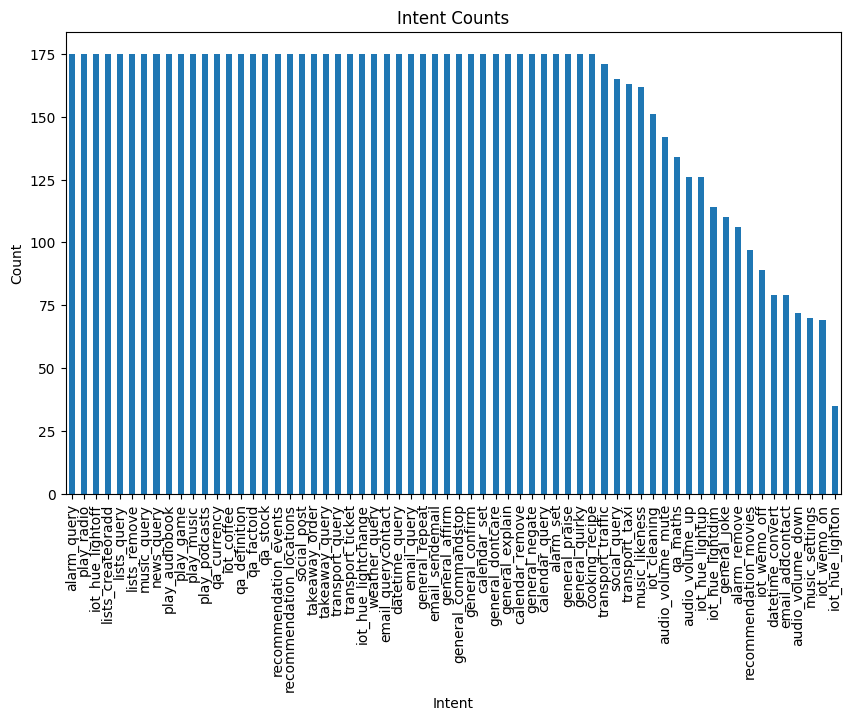

In [5]:
intent_counts = train_data['intent'].value_counts()
plt.figure(figsize=(10, 6))
intent_counts.plot(kind='bar')
plt.title('Intent Counts')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.show()

In [23]:
df_train,df_val=train_test_split(train_data,test_size=0.10 ,random_state=seed)

In [24]:
unique_labels = df_train['intent'].unique()
sampled_df = pd.DataFrame()
for label in unique_labels:
    label_df = df_train[df_train['intent'] == label]
    samples = label_df.sample(n=10, random_state=42)
    sampled_df = sampled_df.append(samples)
sampled_df.reset_index(drop=True, inplace=True)


In [25]:
train_data = sampled_df
val_data = df_val

### Encode the labels

In [26]:
le=LabelEncoder()
train_data['intent']=le.fit_transform(train_data['intent'])
val_data['intent']=le.fit_transform(val_data['intent'])
test_data['intent']=le.transform(test_data['intent'])

In [29]:
print(le.classes_)

['alarm_query' 'alarm_remove' 'alarm_set' 'audio_volume_down'
 'audio_volume_mute' 'audio_volume_up' 'calendar_query' 'calendar_remove'
 'calendar_set' 'cooking_recipe' 'datetime_convert' 'datetime_query'
 'email_addcontact' 'email_query' 'email_querycontact' 'email_sendemail'
 'general_affirm' 'general_commandstop' 'general_confirm'
 'general_dontcare' 'general_explain' 'general_joke' 'general_negate'
 'general_praise' 'general_quirky' 'general_repeat' 'iot_cleaning'
 'iot_coffee' 'iot_hue_lightchange' 'iot_hue_lightdim' 'iot_hue_lightoff'
 'iot_hue_lighton' 'iot_hue_lightup' 'iot_wemo_off' 'iot_wemo_on'
 'lists_createoradd' 'lists_query' 'lists_remove' 'music_likeness'
 'music_query' 'music_settings' 'news_query' 'play_audiobook' 'play_game'
 'play_music' 'play_podcasts' 'play_radio' 'qa_currency' 'qa_definition'
 'qa_factoid' 'qa_maths' 'qa_stock' 'recommendation_events'
 'recommendation_locations' 'recommendation_movies' 'social_post'
 'social_query' 'takeaway_order' 'takeaway_quer

### Setting up BERT Tokenizer

In [27]:
from transformers import AutoTokenizer, TrainingArguments, Trainer

In [28]:
pre_trained_BERTmodel='bert-large-uncased'
BERT_tokenizer=AutoTokenizer.from_pretrained(pre_trained_BERTmodel)

In [29]:
import datasets





def tokenize_data(example):
    encoded_input = BERT_tokenizer(example["speech_text"], padding="max_length", truncation=True)
    return {"input_ids": encoded_input["input_ids"], "attention_mask": encoded_input["attention_mask"], "labels": example["intent"]}






In [30]:
traindataset = datasets.Dataset.from_pandas(train_data)
train_dataset = traindataset.map(tokenize_data)

In [31]:
testdataset = datasets.Dataset.from_pandas(test_data)
test_dataset = testdataset.map(tokenize_data)

In [32]:
valdataset = datasets.Dataset.from_pandas(val_data)
eval_dataset = valdataset.map(tokenize_data)

In [33]:
test_dataset

Dataset({
    features: ['speech_text', 'intent', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1076
})

In [34]:
train_dataset

Dataset({
    features: ['speech_text', 'intent', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 640
})

In [35]:
eval_dataset

Dataset({
    features: ['speech_text', 'intent', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 996
})

In [37]:
args = TrainingArguments(
        output_dir="./output",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=8 ,
        per_device_eval_batch_size=8 ,
        num_train_epochs=20,
        warmup_ratio= 0.1,
        weight_decay= 0.001,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        save_total_limit=1,

    )

In [38]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoModelForSeq2SeqLM,
    AutoConfig,
    BertModel,
)

import torch.nn as nn
from transformers.modeling_outputs import SequenceClassifierOutput


class BertModelWithCustomLossFunction(nn.Module):
    def __init__(self):
        super(BertModelWithCustomLossFunction, self).__init__()
        self.num_labels = len(train_data["intent"].unique())
        self.bert = BertModel.from_pretrained(
            pre_trained_BERTmodel, num_labels=self.num_labels
        )
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(1024, self.num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        output = self.dropout(outputs.pooler_output)
        logits = self.classifier(output)

        loss = None
        if labels is not None:
            # you can define any loss function here yourself
            # see https://pytorch.org/docs/stable/nn.html#loss-functions for an overview
            loss_fct = nn.CrossEntropyLoss()
            # next, compute the loss based on logits + ground-truth labels
            loss = loss_fct(logits.view(-1, self.num_labels), labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [39]:
BERT_model = BertModelWithCustomLossFunction()



Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [41]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [42]:
trainer = Trainer(
        model = BERT_model,
        args = args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=BERT_tokenizer,
        compute_metrics=compute_metrics,)
trainer.train()

/home/cc/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,4.057505,0.049197,0.038592,0.049197,0.027093
2,No log,3.943385,0.090361,0.083441,0.090361,0.063902
3,No log,3.351818,0.380522,0.447788,0.380522,0.339346
4,No log,2.379764,0.621486,0.662304,0.621486,0.585831
5,No log,1.581481,0.771084,0.812856,0.771084,0.756164
6,No log,1.192094,0.756024,0.785533,0.756024,0.740142
7,2.878300,0.871368,0.818273,0.843871,0.818273,0.810388
8,2.878300,0.756022,0.817269,0.841295,0.817269,0.813222
9,2.878300,0.650675,0.838353,0.851532,0.838353,0.835076
10,2.878300,0.704684,0.827309,0.841646,0.827309,0.823102


/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cc/.local/lib/python3.8/site-packages/sklearn/

TrainOutput(global_step=1600, training_loss=0.955415575131774, metrics={'train_runtime': 2215.5072, 'train_samples_per_second': 5.777, 'train_steps_per_second': 0.722, 'total_flos': 0.0, 'train_loss': 0.955415575131774, 'epoch': 20.0})

In [43]:
trainer.predict(test_dataset)

PredictionOutput(predictions=array([[ 3.0418813e+00,  2.2847939e+00,  7.1036892e+00, ...,
         6.9977939e-02,  4.7351891e-01,  4.7073236e-01],
       [ 7.4101081e+00,  2.5634553e+00,  3.5522981e+00, ...,
         4.8027061e-02,  2.0265959e-01, -9.4214134e-02],
       [ 1.9070115e+00,  2.9888432e+00,  8.4658499e+00, ...,
         2.5389883e-01,  2.6605549e-01, -1.5548807e-01],
       ...,
       [ 4.0542561e-01,  3.2148734e-01,  6.6144580e-01, ...,
         4.7626105e-01,  6.7100573e-01,  4.2084455e+00],
       [ 2.5652450e-01, -5.7067230e-02, -1.4687020e-01, ...,
         1.8752125e-01, -8.5096313e-03,  8.5991344e+00],
       [ 2.7794216e+00,  3.6879611e-01,  6.2738127e-01, ...,
         9.7445332e-02,  1.6805193e+00,  6.0069466e+00]], dtype=float32), label_ids=array([ 0,  0,  0, ..., 63, 63, 63]), metrics={'test_loss': 0.6748518943786621, 'test_accuracy': 0.8382899628252788, 'test_precision': 0.8453896996381416, 'test_recall': 0.8382899628252788, 'test_f1': 0.8356089762733068, 'te

In [44]:
trainer.evaluate()

{'eval_loss': 0.6558387875556946,
 'eval_accuracy': 0.8443775100401606,
 'eval_precision': 0.8570499267337782,
 'eval_recall': 0.8443775100401606,
 'eval_f1': 0.8414215741722207,
 'eval_runtime': 34.2179,
 'eval_samples_per_second': 29.108,
 'eval_steps_per_second': 3.653,
 'epoch': 20.0}